In [23]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cmo

# Equations

The equations we are solving are:

\begin{align}
    M_{s1} + M_{s2} + M_{s0} &= M_s ~~~~~ (1)\\
    M_{c1} + M_{c2} + M_{c0} &= M_c ~~~~~ (2) \\
    M_{s1}\delta_1 + M_{s2}\delta_2 + M_{s0}\delta_0 &= M_s\delta_s ~~~~~ (3) \\
    M_{c1}\delta_1 + M_{c2}\delta_2 + M_{c0}\delta_0 &= M_c\delta_c ~~~~~ (4) \\
\end{align}

Also, we have that all $M>0$.

# Analysis 

Want to solve for $M_{s1}, M_{s2}, M_{c1}, M_{c2}$ as well as find $\delta_1$ and $\delta_2$ such that the equations and inequalities are all satisfied.

# Read in data

In [237]:
df = pd.read_csv('2019_09_18_Data_KT_fixed.csv', index_col=0, skiprows=[1])

Set up arrays of $\delta_1$ and $\delta_2$ to find resultant $M$'s.

In [345]:
ndeltas = 50  # number of delta values in each direction
nobs = 12  # number of observations
nvars = 4  # number of variables

d1 = np.linspace(-1,1.5, ndeltas); d2 = np.linspace(-1,1.5, ndeltas)
de1, de2 = np.meshgrid(d1, d2) 
delta1 = de1[:,:,np.newaxis].repeat(12, axis=2) 
delta2 = de2[:,:,np.newaxis].repeat(12, axis=2)

# define constants
delta0 = 0.25
Ms0 = df['Mso'].values[0]
Mc0 = df['Mco'].values[0]

# Solve for $M$'s

We solve for $M_{s2}$ by plugging Equation 1 into Equation 3 to get

$$M_{s2} = \frac{1}{\delta_2 - \delta_1} [M_s\delta_s - M_{s0}\delta_0 + (M_{s0} - M_s)\delta_1] $$

Then we can get $M_{s1}$ from Equation 1.

Similarly, we solve for $M_{c2}$ by plugging Equation 2 into Equation 4 to get

$$M_{c2} = \frac{1}{\delta_2 - \delta_1} [M_c\delta_c - M_{c0}\delta_0 + (M_{c0} - M_c)\delta_1] $$

Then we can get $M_{c1}$ from Equation 2.

Note that if we originally solved for $M_{s1}$ instead of $M_{s2}$ by plugging Equation 1 into 3, we get a similar form but flipped for $\delta_1$ and $\delta_2$, giving us symmetric results.

In [346]:
ddelta = (delta2-delta1)
Ms2 = (df['Ms'].values*df['deltas'].values - Ms0*delta0 + (Ms0-df['Ms'].values)*delta1)/ddelta;

/Users/kthyng/miniconda3/envs/cart/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [347]:
Ms1 = df['Ms'].values - Ms0 - Ms2 

In [348]:
Mc2 = (df['Mc'].values*df['deltac'].values - Mc0*delta0 + (Mc0-df['Mc'].values)*delta1)/(delta2-delta1)

/Users/kthyng/miniconda3/envs/cart/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [349]:
Mc1 = df['Mc'].values - Mc0 - Mc2 

In [360]:
outputs = np.stack([Mc1, Mc2, Ms1, Ms2], axis=-1)
# mask out infinite values
outputs = np.ma.masked_where(np.isinf(outputs), outputs)

In [368]:
vmax

196.71775200000022

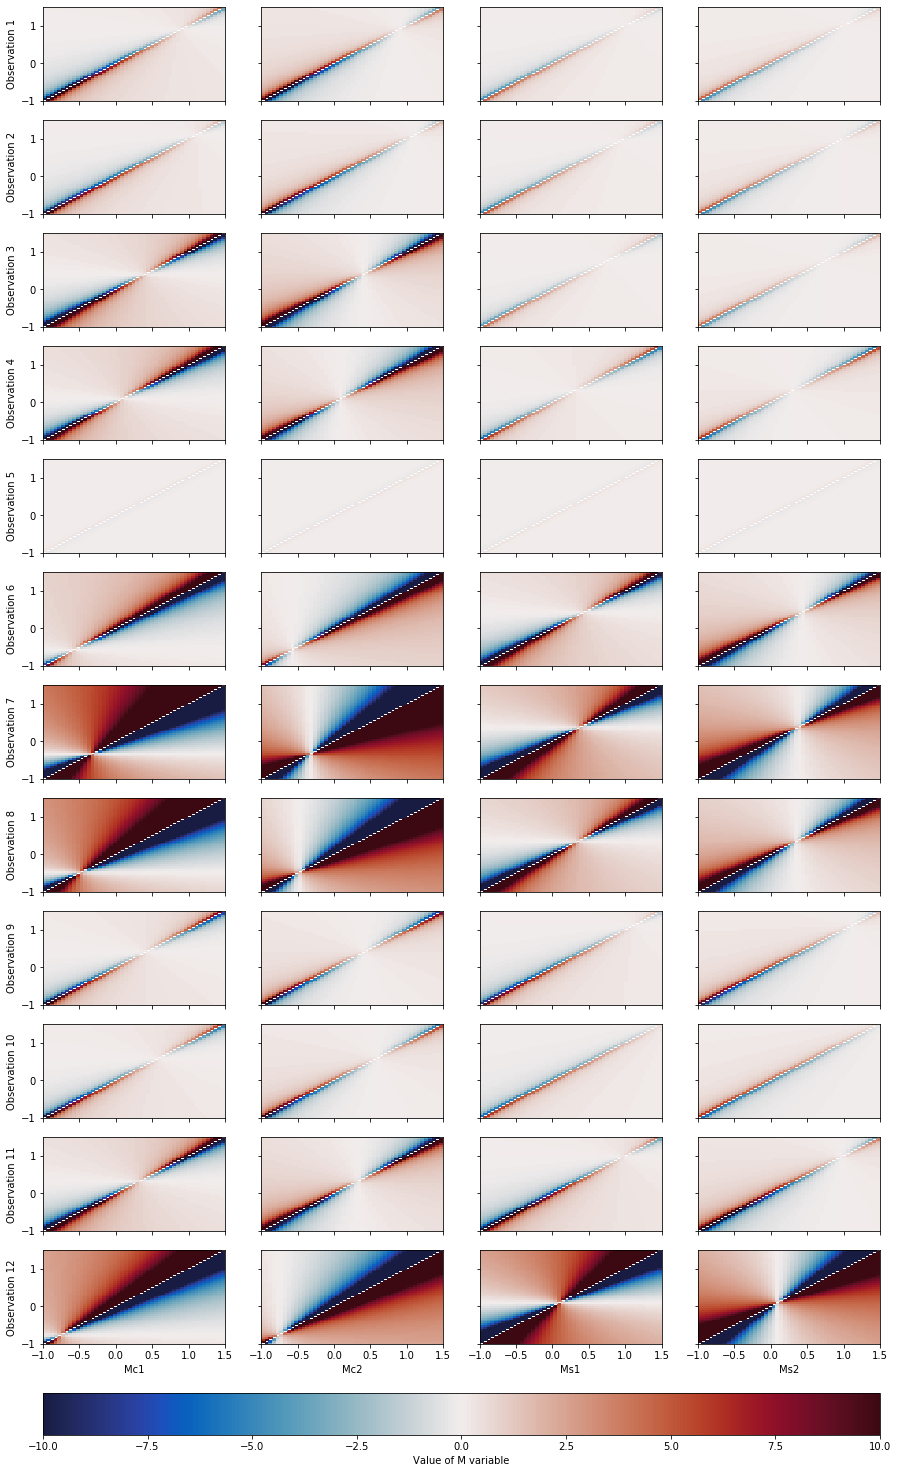

In [382]:
names = ['Mc1', 'Mc2', 'Ms1', 'Ms2']
outputs = np.stack([Mc1, Mc2, Ms1, Ms2], axis=-1)  # nvars x numds x nobs x nvars
# mask out infinite values
outputs = np.ma.masked_where(np.isinf(outputs), outputs)

penalty = np.zeros((ndeltas, ndeltas))  # to integrate penalty over the loops

vmax = 10  # abs(outputs.max())
vmin = -vmax

fig, axes = plt.subplots(nobs, nvars, sharex=True, sharey=True, figsize=(15,30))

for irow in range(nobs):  # looping over the 12 observations nobs
    for icol in range(nvars):  # looping over the 4 M's we solve for nvars
        ax = axes[irow, icol]
        
        if icol == 0:
            ax.set_ylabel('Observation %i' % (int(irow) + 1))
            
        if irow == nobs-1:
            ax.set_xlabel(names[icol])
            
        var = outputs[:,:,irow,icol].copy()  # rename variable for this loop
                
        # pull out numbers that are <0
        ind = var<0
        # for those numbers, penalty of ^2 for distance away from
        # penalty stores the sum of the penalty squared across the variables (4 M's) and
        # the 12 observations, so over 36 matrices
        penalty[ind] += var[ind]**2
             
        # plot the individual matrices for inspection
        mappable = ax.pcolormesh(delta1[:,:,0], delta2[:,:,0], var, cmap=cmo.balance, vmin=vmin, vmax=vmax)
        
cb = fig.colorbar(mappable, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.03)
cb.set_label('Value of M variable')

# Look at penalty

For each variable/observation combination, the distance of the resulting value (for each $\delta_1$, $\delta_2$ pair) is squared and added to the penalty matrix if it is less than zero. Here we plot. The colorbar range is very small in order to zoom into the area of the plot with smallest penalties.

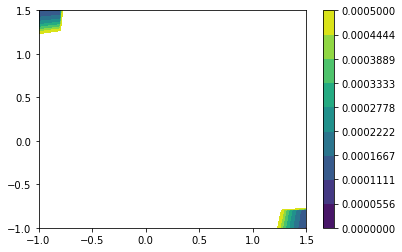

In [383]:
plt.contourf(delta1[:,:,0], delta2[:,:,1], penalty, levels=np.linspace(0,0.0005,10))
plt.colorbar()

In [385]:
penalty[-1,0]  # among the smallest penalties

0.000100220112

In [387]:
i = -1; j=0
de1[i,j], de2[i,j]  # corresponds to delta1=-1, delta2=1.5

(-1.0, 1.5)

Plot of resultant $M_s$ type variables for given $\delta_1$, $\delta_2$ values of -1, 1.5 (respectively)

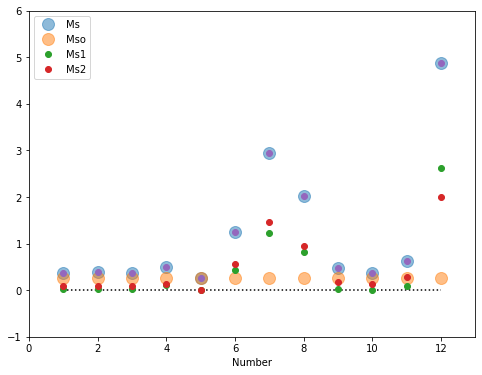

In [388]:
ax = df[['Ms','Mso']].plot(marker='o', legend=False, linestyle='', markersize=12, alpha=0.5, figsize=(8,6))
ax.plot(df.index, Ms1[i,j,:], 'o', label='Ms1')
ax.plot(df.index, Ms2[i,j,:], 'o', label='Ms2')
ax.hlines(0, 1, 12, linestyle=':')
plt.legend(['Ms', 'Mso', 'Ms1', 'Ms2'], loc='upper left')
ax.axis([0, 13, -1, 6])

ax.plot(df.index, Ms1[i,j,:] + Ms2[i,j,:] + df['Mso'], 'o')

Plot of resultant $M_c$ type variables for given $\delta_1$, $\delta_2$ values of -1, 1.5 (respectively)

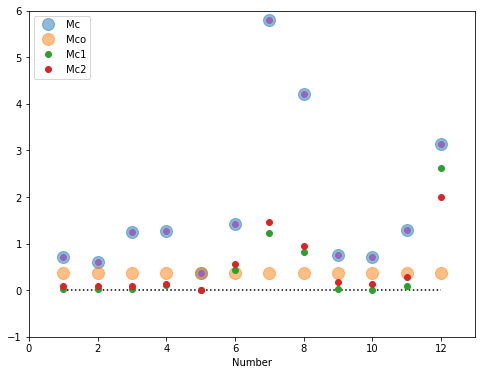

In [390]:
ax = df[['Mc','Mco']].plot(marker='o', legend=False, linestyle='', markersize=12, alpha=0.5, figsize=(8,6))
ax.plot(df.index, Ms1[i,j,:], 'o', label='Mc1')
ax.plot(df.index, Ms2[i,j,:], 'o', label='Mc2')
ax.hlines(0, 1, 12, linestyle=':')
plt.legend(['Mc', 'Mco', 'Mc1', 'Mc2'], loc='upper left')
ax.axis([0, 13, -1, 6])

ax.plot(df.index, Mc1[i,j,:] + Mc2[i,j,:] + df['Mco'], 'o')

# Follow up questions

1. Do you have similar equations for other studies? Jess you said that usually people just assume the form for $\delta_1$ and $\delta_2$. Do previous studies publish enough information to use this same approach and compare with their assumed values?